<a href="https://colab.research.google.com/github/ShubhamDeshmukh27/Face-emotion-detection-deep-learning-project/blob/main/Self_notebook_Face_emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name**

**Live Class Monitoring System(Face Emotion Recognition)**

# **Project Introduction**

The Indian education landscape has been undergoing rapid changes for the past 10 years owing to
the advancement of web-based learning services, specifically, eLearning platforms.

Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India
is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market
is growing on a rapid scale, there are major challenges associated with digital learning when
compared with brick and mortar classrooms. One of many challenges is how to ensure quality
learning for students. Digital platforms might overpower physical classrooms in terms of content
quality but when it comes to understanding whether students are able to grasp the content in a live
class scenario is yet an open-end challenge.


In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the
class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who
need special attention. Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the
mood. Because of this drawback, students are not focusing on content due to lack of surveillance.
While digital platforms have limitations in terms of physical surveillance but it comes with the power of
data and machines which can work for you. It provides data in the form of video, audio, and texts
which can be analysed using deep learning algorithms. Deep learning backed system not only solves
the surveillance issue, but it also removes the human bias from the system, and all information is no
longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.


# **Problem Statements**

We will solve the above-mentioned challenge by applying deep learning algorithms to live video data.

The solution to this problem is by recognizing facial emotions.


# **What is Face Emotion Recognition?**

Facial emotion recognition is the process of detecting human emotions from facial expressions. The human brain recognizes emotions automatically, and software has now been developed that can recognize emotions as well.

# **Importing Libraries**


In [1]:
import os
import cv2
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## CNN Models ##
import keras
import tensorflow as tf
from tensorflow.keras import optimizers
from keras.utils import np_utils
from keras.regularizers import l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D,concatenate
from keras.models import Model
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import load_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# Parameters

In [2]:
batch_size = 32
num_epochs = 50
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
base_path = 'models/'
shape_x = 48
shape_y = 48
image_size=(48,48)

# **Reading the Data**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Deep learning Project

/content/gdrive/MyDrive/Colab Notebooks/Deep learning Project


In [5]:
import tarfile

fname = 'fer2013.tar.gz'
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

In [6]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Deep learning Project/fer2013/fer2013.csv')

In [7]:
# Printing shape of the data
print(df.shape)

(35887, 3)


In [8]:
# Return the first 5 rows.
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
# Return unique values emotion
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [10]:
# Dictionary mapping for individual emotions
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


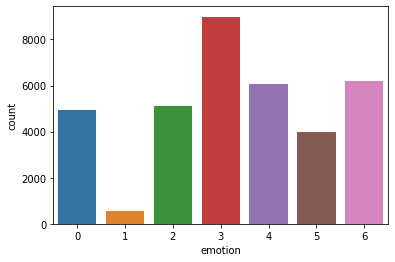

In [11]:
# Plotting distribution of emotions
sns.countplot(df.emotion)
plt.show()

From above plot we can observe that majority of the classes belongs to **3:Happy**, **4:Sad** and **6:Neutral** on the otherside **1:disgust** and **5:surprise** are less in classes.


# **Displaying Images**

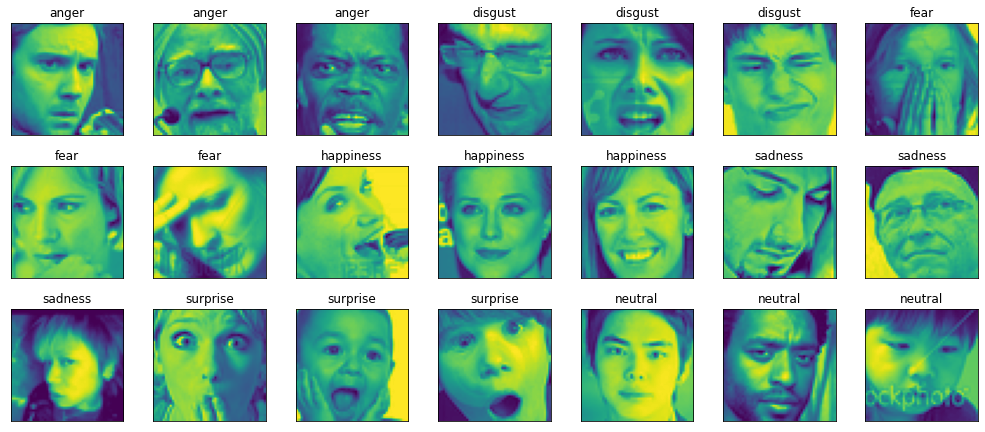

In [12]:
# Visulize sample dataset
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

## Preprocessing

In [13]:
df['pixels']=df['pixels'].astype("string")
pixels = df['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.strip().split(' ',48*48)]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'),image_size)
    faces.append(face.astype('float32'))
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
faces /= 127.5
faces -= 1.
emotions = pd.get_dummies(df['emotion']).to_numpy()

## Data Augmentation

**Data Augmentation**:- taking the batch and apply some series of random transformations (random rotation, resizing, shearing) to increase generalizability of model.

In [14]:
# data generator Generate batches of tensor image data with real-time data augmentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,#Set input mean to 0 over the dataset, feature-wise.
                        featurewise_std_normalization=False,# Divide inputs by std of the dataset, feature-wise.
                        rotation_range=10,      # randomly rotate images in the range (degrees, 0 to 180)
                        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                        height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
                        zoom_range=.1,          # randomly zoom into images
                        horizontal_flip=True)   # randomly flip images

**ImageDataGenerator**

horizontal and vertical shift => moving all pixels of image in one direction

1. width_shift_range ( horizonatal shift)

2. height_shift_range (vertical shift)
3. floating num [0- 1] --> % of shift

*  horizontal n vertical flips augmentation ==>reversing rows or cols of pixels --> True or False

*  Random rotation --> 0 - 360 degrees --> rotation_range = 90 ==> means random rotation to image blw 0 and 90 degrees
*  random brightness --> randomly darkens or brightens images ==> brightness_range =[0.2,1.0] --> means darkens or brightens if pixel is blw 0.2 and 1
*  random zoom
1. either adds pixel or subtract pixels in image . [1-value, 1+value]
2. for example , zoom_range = .3 --> range [0.7, 1.3] or blw 70%(zoom in) and 130% (zoomout)


# **Splitting data into train and test datset**

In [15]:
#train test split
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.3,shuffle=True)
xval,xtest,yval,ytest=train_test_split(xtest,ytest,test_size=0.3,shuffle=True)

In [16]:
# Checking shapes
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape, xval.shape, xtest.shape, yval.shape, ytest.shape

((25120, 48, 48, 1),
 (3231, 48, 48, 1),
 (25120, 7),
 (3231, 7),
 (7536, 48, 48, 1),
 (3231, 48, 48, 1),
 (7536, 7),
 (3231, 7))

## Method 1: Directly Using DeepFace :

Deepface is a lightweight face recognition and facial attribute analysis (age, gender, emotion and race) framework for python. 


[PAPER](https://en.wikipedia.org/wiki/DeepFace)

In [17]:
# Installing DeepFace
!pip install deepface

     |████████████████████████████████| 61 kB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3 MB 29.8 MB/s 
  Created wheel for gdown: filename=gdown-3.13.1-py3-none-any.whl size=9920 sha256=ece7a5e76342d05c7dab740ebd9a9701fa875dc9bfc399ab4902275a1dad3e61
  Stored in directory: /root/.cache/pip/wheels/f2/8d/0b/2e7e6c725f898bd7ef654b660528e459a4d79f3a68976ca9fc
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [ ]:
# Upload A file from local Drive
from google.colab import files
uploaded = files.upload()

Saving neutral.jpg to neutral (1).jpg


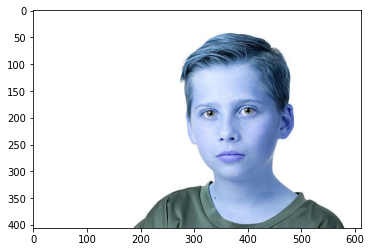

In [18]:
# Image Show
import cv2
import matplotlib.pyplot as plt
img_array=cv2.imread("neutral.jpg")
plt.imshow(img_array)

In [19]:
# Analyze Image using DeepFace
from deepface import DeepFace
obj = DeepFace.analyze(img_path = "neutral.jpg", actions = ['age', 'gender', 'race', 'emotion'])
print(obj["age"]," years old ",obj["dominant_race"]," ",obj["dominant_emotion"]," ", obj["gender"])

Directory  /root /.deepface created
Directory  /root /.deepface/weights created
facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 50.7MB/s]


age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5
100%|██████████| 539M/539M [00:08<00:00, 59.9MB/s]


gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5
100%|██████████| 537M/537M [00:09<00:00, 59.7MB/s]


race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5
100%|██████████| 537M/537M [00:08<00:00, 60.1MB/s]
Action: emotion: 100%|██████████| 4/4 [00:32<00:00,  8.05s/it]

32  years old  white   sad   Woman


The actual emotion in the Picture above is NEUTRAL Face but using DeepFace I found the prediction is ANGRY.
It's Better to train my own model.

## Method 2: ResNet

[Paper](https://d2l.ai/chapter_convolutional-modern/resnet.html)

![](https://www.researchgate.net/publication/338603223/figure/fig1/AS:847598516711425@1579094642237/ResNet-50-architecture-26-shown-with-the-residual-units-the-size-of-the-filters-and.png)

**ResNet-50** architecture shown with the residual units, the size of the filters and the outputs of each convolutional layer. DRF extracted from the last convolutional layer of this network is also shown. Key: The notation k × k, n in the convolutional layer block denotes a filter of size k and n channels. FC 1000 denotes the fully connected layer with 1000 neurons. The number on the top of the convolutional layer block represents the repetition of each unit. nClasses represents the number of output classes.


In [20]:
WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.2/'
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.2/'
                       'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

backend = None
layers = None
models = None
keras_utils = None


def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = keras.layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = keras.layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = keras.layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = keras.layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = keras.layers.add([x, input_tensor])
    x = keras.layers.Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    filters1, filters2, filters3 = filters
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = keras.layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = keras.layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = keras.layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = keras.layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = keras.layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = keras.layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = keras.layers.add([x, shortcut])
    x = keras.layers.Activation('relu')(x)
    return x


def ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling=None, classes=7):

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 7:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    if input_tensor is None:
        img_input = keras.layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = keras.layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    bn_axis = 3


    x = keras.layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = keras.layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = keras.layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    if include_top:
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = keras.layers.Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = keras.layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = keras.layers.GlobalMaxPooling2D()(x)
        else:
            warnings.warn('The output shape of `ResNet50(include_top=False)` '
                          'has been changed since Keras 2.2.0.')

    inputs = img_input
    # Create model.
    model = keras.models.Model(inputs, x, name='resnet50')

    return model

In [21]:
resnet50= ResNet50()

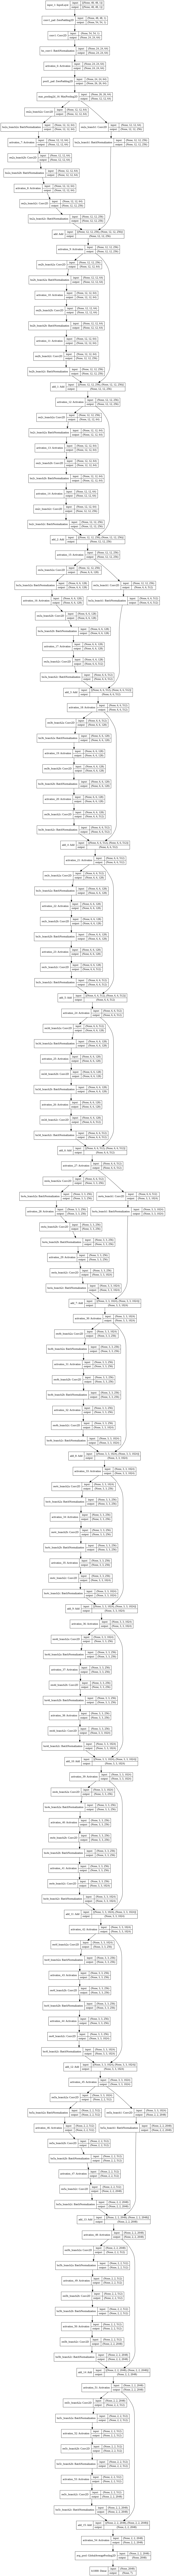

In [22]:
plot_model(resnet50, to_file='resnet50.png', show_shapes=True, show_layer_names=True)

In [23]:
resnet50.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
resnet50.summary() #gives the information about the architecture and configuration of the neural network.

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 24, 24, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

# Modelling

# Training 
## ResNet

In [24]:
early_stop = EarlyStopping('val_loss', patience=50, min_delta=0, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=int(50/4), min_delta=0.00001,model='auto')
trained_models_path = base_path + '_Resnet'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [25]:
resnet_history =resnet50.fit(data_generator.flow(xtrain, ytrain, batch_size),
          steps_per_epoch=len(xtrain) / batch_size, 
          epochs=50, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(xtest,ytest))

Epoch 1/50
785/785 [==============================] - 105s 122ms/step - loss: 2.1021 - accuracy: 0.2666 - val_loss: 1.9737 - val_accuracy: 0.2810

Epoch 00001: val_loss improved from inf to 1.97365, saving model to models/_Resnet.01-0.28.hdf5
Epoch 2/50
785/785 [==============================] - 95s 121ms/step - loss: 1.8421 - accuracy: 0.3138 - val_loss: 10.4563 - val_accuracy: 0.2878

Epoch 00002: val_loss did not improve from 1.97365
Epoch 3/50
785/785 [==============================] - 94s 120ms/step - loss: 1.6736 - accuracy: 0.3710 - val_loss: 2.0235 - val_accuracy: 0.3835

Epoch 00003: val_loss did not improve from 1.97365
Epoch 4/50
785/785 [==============================] - 94s 120ms/step - loss: 1.5753 - accuracy: 0.3992 - val_loss: 1.4572 - val_accuracy: 0.4246

Epoch 00004: val_loss improved from 1.97365 to 1.45718, saving model to models/_Resnet.04-0.42.hdf5
Epoch 5/50
785/785 [==============================] - 94s 120ms/step - loss: 1.5139 - accuracy: 0.4309 - val_loss: 1

It took around 25-30 minutes to run all 70 epochs. The training gave the accuracy of 67% and va_accuracy of 60.85%. It seems good.



# **Plotting Accuracy & Loss**

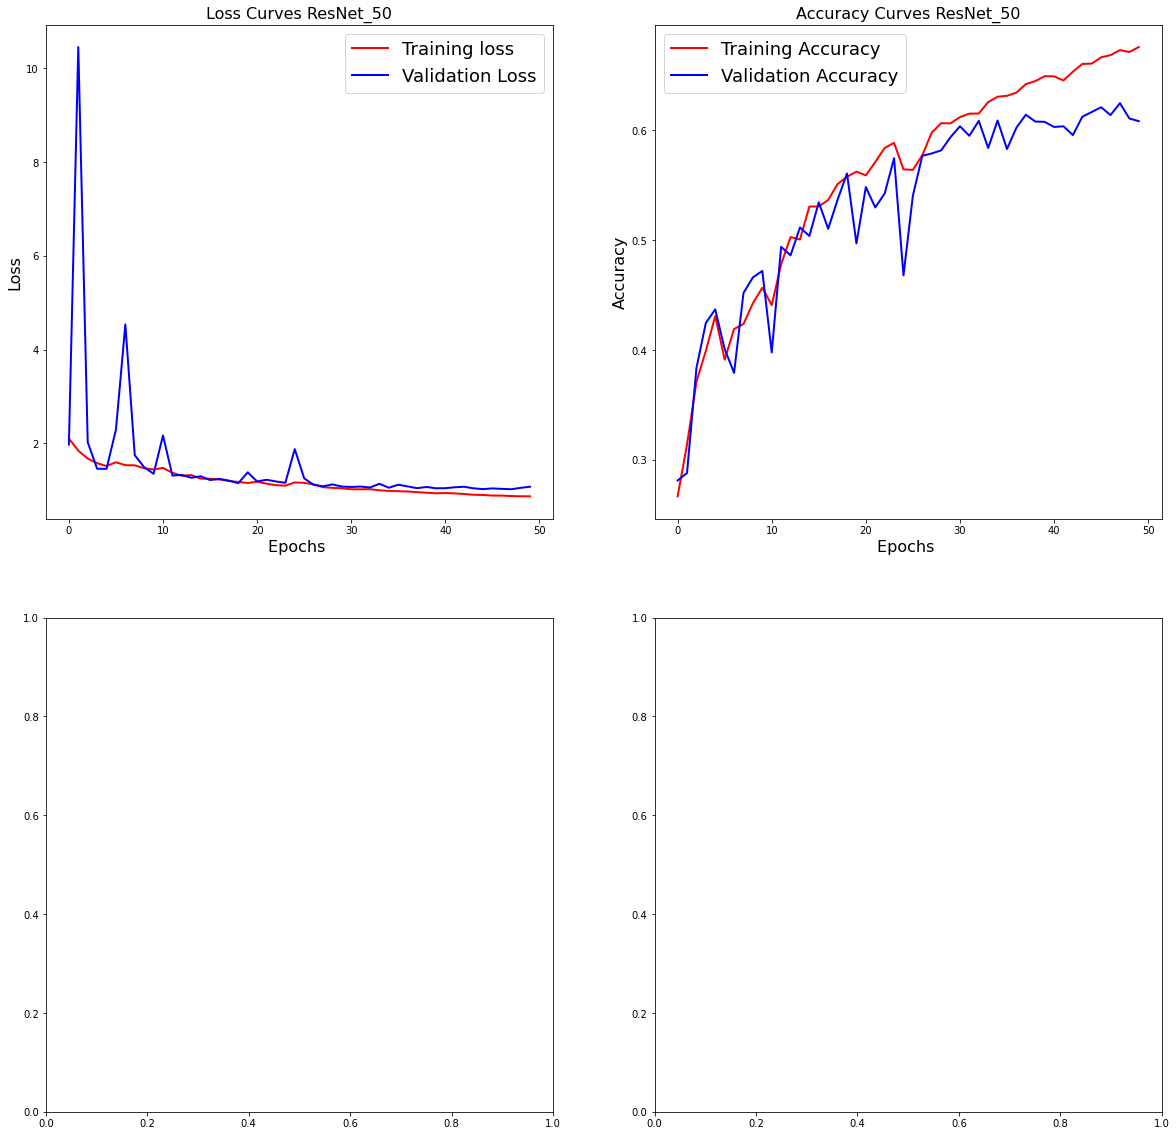

In [26]:
# loss and accuracy curve for Resnet50 model
fig,axes=plt.subplots(2,2,figsize=(20, 20))
for (m,history), ax in zip({'ResNet_50':resnet_history}.items(),axes):
    # Loss Curves    
    ax[0].plot(history.history['loss'],'r',linewidth=2.0)
    ax[0].plot(history.history['val_loss'],'b',linewidth=2.0)
    ax[0].legend(['Training loss', 'Validation Loss'],fontsize=18)
    ax[0].set_xlabel('Epochs ',fontsize=16)
    ax[0].set_ylabel('Loss',fontsize=16)
    ax[0].set_title('Loss Curves '+m,fontsize=16)
 
    # Accuracy Curves
    ax[1].plot(history.history['accuracy'],'r',linewidth=2.0)
    ax[1].plot(history.history['val_accuracy'],'b',linewidth=2.0)
    ax[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    ax[1].set_xlabel('Epochs ',fontsize=16)
    ax[1].set_ylabel('Accuracy',fontsize=16)
    ax[1].set_title('Accuracy Curves '+m,fontsize=16)

In [27]:
# saving the plot
plt.savefig('plots.png')

<Figure size 432x288 with 0 Axes>

# Classificastion Reports

In [28]:
for model in [resnet50]:
    ypred=model.predict(xtest)
    ypred_=np.argmax(ypred, axis=1)
    ytest_=np.argmax(ytest, axis=1)
    print(classification_report(ytest_, ypred_,digits=3))

              precision    recall  f1-score   support

           0      0.536     0.457     0.493       444
           1      0.350     0.553     0.429        38
           2      0.444     0.465     0.454       456
           3      0.882     0.777     0.826       801
           4      0.529     0.479     0.503       564
           5      0.675     0.787     0.727       375
           6      0.517     0.620     0.564       553

    accuracy                          0.608      3231
   macro avg      0.562     0.591     0.571      3231
weighted avg      0.618     0.608     0.610      3231



From above classification report it is seen that the f1 score is good.

# Confusion Matrix

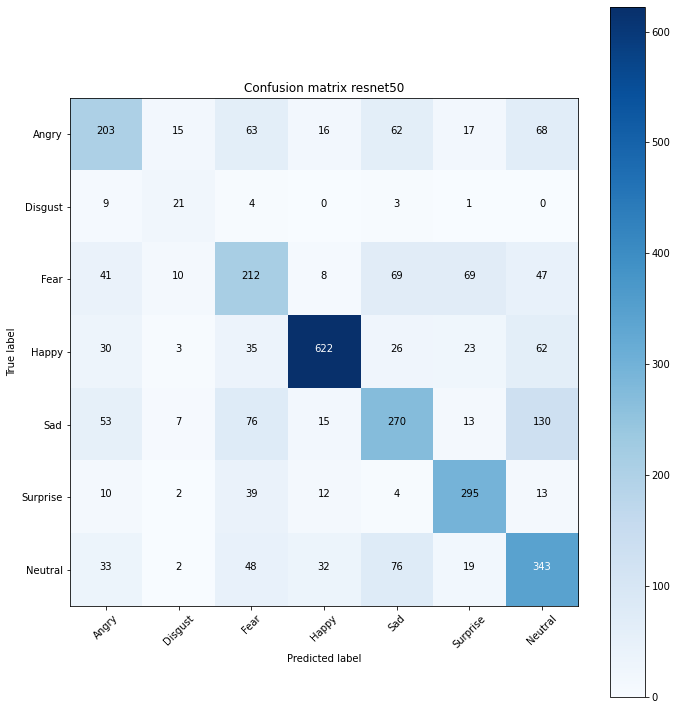

In [29]:
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure


for model,i in zip([resnet50],[1,2,3]):
    fig = figure(figsize=(10, 10))
    
    ypred=model.predict(xtest)
    rounded_predections=np.argmax(ypred, axis=1)
    rounded_labels=np.argmax(ytest, axis=1)
    cm = confusion_matrix(rounded_labels, rounded_predections)
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    title='Confusion matrix '+model.name
    

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_'+model.name+'.png')
    plt.show()
    

From the confusion metrix above we observe the emotiions that are correctly predicted w.r.t actual emotions. 

In [30]:
# Save best Model
resnet50.save('resnet_model.h5')

# **Real Time Video Face Detection Using Local Webcam**

In [31]:
# import dependencies
from IPython.display import display, Javascript, Image,clear_output
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [32]:

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [33]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [34]:

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [35]:
def face_detect():
  import cv2
  from PIL import Image
  import numpy as np
  import os
  from keras.models import load_model
  from time import sleep
  from keras.preprocessing.image import img_to_array
  from keras.preprocessing import image
# start streaming video from webcam
  video_stream()
# label for video
  label_html = 'Capturing...'
# initialze bounding box to empty
  bbox = ''
  count = 0
  face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + '/content/gdrive/MyDrive/Colab Notebooks/Deep learning Project/haarcascade_frontalface_default.xml') # Face Detection
  classifier =load_model('/content/gdrive/MyDrive/Colab Notebooks/Deep learning Project/resnet_model.h5')  #Load model
  emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise'] 

  while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
      break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,255,0),2)
      roi_gray = gray[y:y+h,x:x+w]
      roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)  ##Face Cropping for prediction
      if np.sum([roi_gray])!=0:
        roi = roi_gray.astype('float')/255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi,axis=0) ## reshaping the cropped face image for prediction
        prediction = classifier.predict(roi)[0]   #Prediction
        label=emotion_labels[prediction.argmax()]
        label_position = (x,y)
        cv2.putText(bbox_array,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)   # Text Adding
      else:
        cv2.putText(bbox_array,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)

    



    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

In [36]:
# Finally detecting the face with live webcam
face_detect()

<IPython.core.display.Javascript object>